# Container fullness detection using CNN


## 1. Import tensorflow

In [72]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 2. Loading the dataset applying several augmentations

In [73]:
datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=120,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest',
                             validation_split=0.2
                            )

All the training images used during initial setup training can be found in the repository in the file '*Dataset.zip*'

In [74]:
train = datagen.flow_from_directory('Dataset/train',
                                       target_size=(100, 100),
                                       class_mode='categorical',
                                       color_mode='grayscale',
                                        subset='training'
                                      )
validation = datagen.flow_from_directory('Dataset/train',
                                       target_size=(100, 100),
                                       class_mode='categorical',
                                       color_mode='grayscale',
                                         subset='validation'
                                  )

Found 809 images belonging to 3 classes.
Found 201 images belonging to 3 classes.


The 3 classes that are mentioned above are:

In [59]:
class_names = ['Empty', 'Full', 'Half-full']

## 3. Here's what the few training samples look like:

In [54]:
images, labels = train.next()

In [95]:
images[0].shape

(100, 100, 1)

In [55]:
labels

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

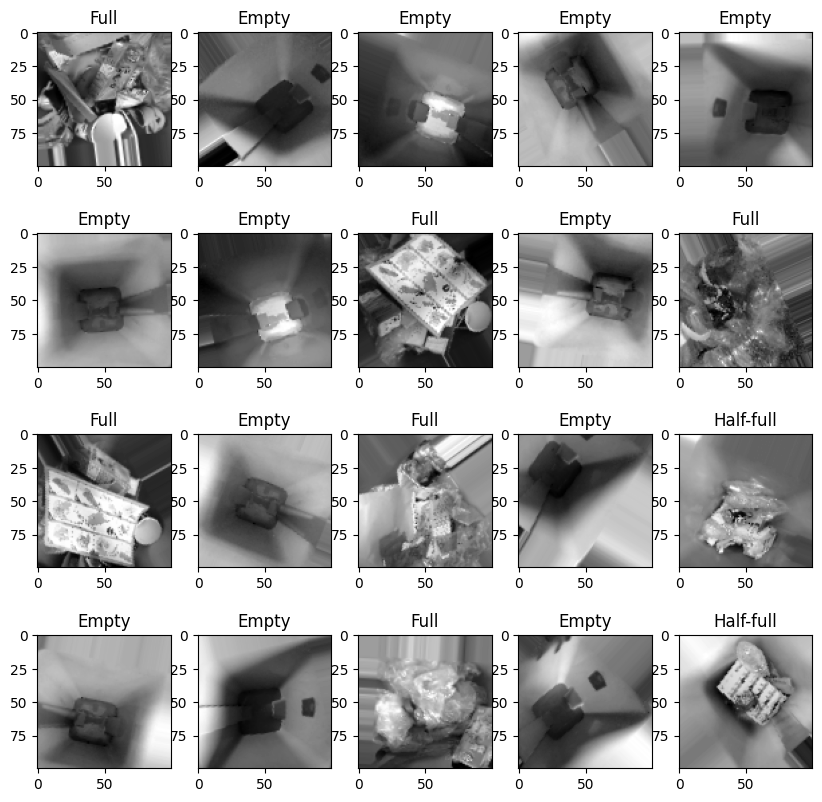

In [61]:
fig, axes = plt.subplots(4, 5, figsize=(10, 10))
k = 0;

for i in range(4):
    for j in range (5):
        ax = axes[i][j]
        ax.set_title(class_names[np.argmax(labels[k])])
        ax.imshow(images[k], cmap='gray')
        k += 1

## Hyper parameter tuning

Go to [this link](https://keras.io/guides/keras_tuner/getting_started/) to get started with hyperparameter tuning with Keras 

In [11]:
from keras_tuner.tuners import RandomSearch
from keras_tuner import HyperModel

The function which builds the model with defined hyperparameters.

In [12]:
class MyHyperModel(HyperModel):
    def build(self, hp):
        poolSize = hp.Choice('pool_size', values=[2, 3, 4])
        model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(hp.Int('conv_units', min_value=20, max_value=40, step=2), (3, 3), input_shape=(100, 100, 1)),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(poolSize, poolSize)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(hp.Int('dense_units', min_value=32, max_value = 160, step=32), activation='relu'),
        tf.keras.layers.Dropout(hp.Choice('dropout', values=[0.1, 0.2, 0.3])),
        tf.keras.layers.Dense(3, activation='softmax')
        ])
        model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [16, 20, 32]),
            **kwargs,
        )

In [13]:
tuner = RandomSearch(
    MyHyperModel(),
    objective='val_accuracy',
    max_trials=10,
    overwrite=True,
    directory='.hp_tuning_checkpoints',
    project_name='smart_garbage',
   )

In [14]:
tuner.search(train, validation_data=validation, epochs=25, callbacks=[tf.keras.callbacks.EarlyStopping('val_accuracy', patience=2)])

Trial 10 Complete [00h 07m 52s]
val_accuracy: 0.984455943107605

Best val_accuracy So Far: 1.0
Total elapsed time: 01h 39m 58s
INFO:tensorflow:Oracle triggered exit


In [15]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"The best hyperparameters are: \n{best_hps.values}")

The best hyperparameters are: 
{'pool_size': 3, 'conv_units': 22, 'dense_units': 160, 'dropout': 0.3, 'batch_size': 16}


In [16]:
tuner.results_summary();

Results summary
Results in .hp_tuning_checkpoints\smart_garbage
Showing 10 best trials
Trial summary
Hyperparameters:
pool_size: 3
conv_units: 22
dense_units: 160
dropout: 0.3
batch_size: 16
Score: 1.0
Trial summary
Hyperparameters:
pool_size: 4
conv_units: 36
dense_units: 32
dropout: 0.1
batch_size: 32
Score: 1.0
Trial summary
Hyperparameters:
pool_size: 3
conv_units: 38
dense_units: 96
dropout: 0.2
batch_size: 16
Score: 0.9948186278343201
Trial summary
Hyperparameters:
pool_size: 2
conv_units: 30
dense_units: 96
dropout: 0.1
batch_size: 32
Score: 0.9948186278343201
Trial summary
Hyperparameters:
pool_size: 2
conv_units: 34
dense_units: 96
dropout: 0.2
batch_size: 32
Score: 0.9948186278343201
Trial summary
Hyperparameters:
pool_size: 4
conv_units: 26
dense_units: 96
dropout: 0.1
batch_size: 20
Score: 0.9896373152732849
Trial summary
Hyperparameters:
pool_size: 3
conv_units: 32
dense_units: 96
dropout: 0.3
batch_size: 16
Score: 0.984455943107605
Trial summary
Hyperparameters:
pool_size

## 4. Building the model

Now we'll build the model. Since most of the models during hyperparameter tuning have score above 0.9, the model can be built on any set of hyperparameters.

The dataset employed is slightly skewed. So monitoring a weighted score like f1 score gives a much better idea about the model performance.

In [75]:
import tensorflow_addons as tfa
f1_score = tfa.metrics.F1Score(num_classes=3, average="weighted")

In [76]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), input_shape=(100, 100, 1)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', f1_score])

history = tf.keras.callbacks.History()

In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 98, 98, 32)        320       
                                                                 
 activation_1 (Activation)   (None, 98, 98, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 49, 49, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 76832)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               9834624   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                      

## 5. Training

In [77]:
model.fit(train, steps_per_epoch=len(train),batch_size=20, epochs=10, validation_data=validation, callbacks=[history])

Epoch 1/10
26/26 [==============================] - 89s 3s/step - loss: 1.5775 - accuracy: 0.6094 - f1_score: 0.6026 - val_loss: 0.4690 - val_accuracy: 0.7612 - val_f1_score: 0.7553
Epoch 2/10
26/26 [==============================] - 66s 2s/step - loss: 0.3272 - accuracy: 0.9023 - f1_score: 0.8998 - val_loss: 0.3088 - val_accuracy: 0.8308 - val_f1_score: 0.8323
Epoch 3/10
26/26 [==============================] - 80s 3s/step - loss: 0.1899 - accuracy: 0.9506 - f1_score: 0.9503 - val_loss: 0.1268 - val_accuracy: 0.9801 - val_f1_score: 0.9800
Epoch 4/10
26/26 [==============================] - 67s 3s/step - loss: 0.1502 - accuracy: 0.9580 - f1_score: 0.9577 - val_loss: 0.1022 - val_accuracy: 0.9801 - val_f1_score: 0.9800
Epoch 5/10
26/26 [==============================] - 65s 2s/step - loss: 0.1317 - accuracy: 0.9629 - f1_score: 0.9628 - val_loss: 0.1179 - val_accuracy: 0.9801 - val_f1_score: 0.9803
Epoch 6/10
26/26 [==============================] - 68s 3s/step - loss: 0.1266 - accuracy:

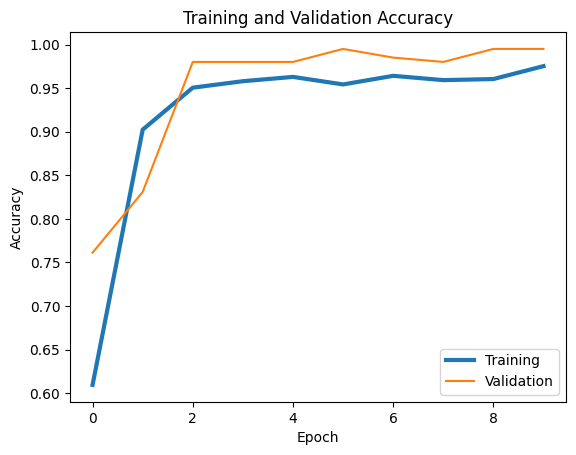

In [78]:
plt.plot(history.history['accuracy'], label='Training', linewidth=3)
plt.plot(history.history['val_accuracy'],label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

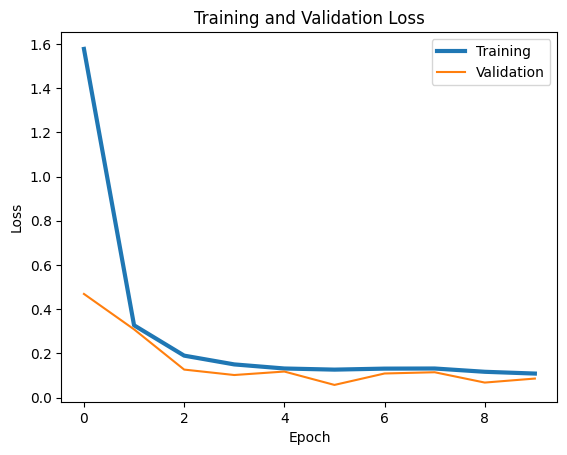

In [79]:
plt.plot(history.history['loss'], label='Training', linewidth=3)
plt.plot(history.history['val_loss'],label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

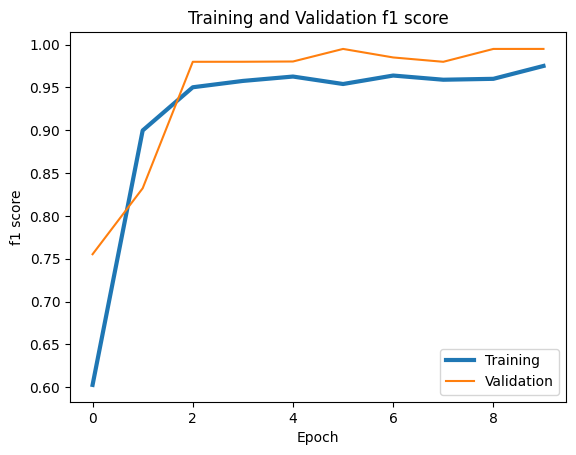

In [80]:
plt.plot(history.history['f1_score'], label='Training', linewidth=3)
plt.plot(history.history['val_f1_score'],label='Validation')
plt.title('Training and Validation f1 score')
plt.xlabel('Epoch')
plt.ylabel('f1 score')
plt.legend()
plt.show()

## 6. Evaluating the performance of model on unseen data

In [11]:
test = datagen.flow_from_directory('Dataset/test',
                                       target_size=(100, 100),
                                       batch_size=20,
                                       class_mode='sparse',
                                       color_mode='grayscale',
                                  )

Found 141 images belonging to 3 classes.


In [28]:
test_history=model.evaluate(test, verbose=2)

8/8 - 10s - loss: 0.3910 - accuracy: 0.8652 - 10s/epoch - 1s/step


## 7. Exporting the model

In [14]:
model.save("model/garbage_model.h5")

## 8. Prediction using the model example

In [3]:
loaded_model = tf.keras.models.load_model("model/fullness_determination_model.h5")

In [4]:
import cv2

In [18]:
image = cv2.imread('Dataset/Test/half-full/image165.jpg', cv2.IMREAD_GRAYSCALE)

In [19]:
image.shape

(1200, 1600)

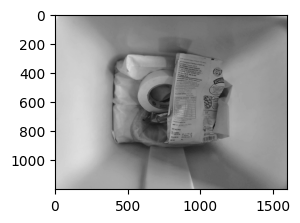

In [20]:
plt.figure(figsize=(3, 3))
plt.imshow(image, cmap='gray')

Preprocessing the image(half-full) to be fed into the model:

In [21]:
input_image = cv2.resize(image, (100, 100))
input_image = input_image.reshape(-1, 100, 100, 1)
input_image = input_image / 255

The image is now ready.

In [22]:
input_image.shape

(1, 100, 100, 1)

In [23]:
prediction = loaded_model.predict(input_image);

1/1 [==============================] - 1s 539ms/step


The highest probability is of the half-full class (integer labeling is used from 0 to 2 for empty, full and half-full
respectively) is shown below, which is correct.

In [24]:
prediction

array([[0.00261402, 0.00548145, 0.9919045 ]], dtype=float32)

## 9. Feature maps visualisation 

Function to plot out feature maps of a layer.

In [130]:
def plotFeatureMaps(inputImage, model, index):
    #deriving a model which outputs feature maps 
    custom_model = tf.keras.models.Model(
    inputs=model.inputs,
    outputs=model.layers[index].output) 
        
    #output from the custom_model is now output feature maps of the layer at index
    features = custom_model.predict(inputImage)
    print(features[0, :, :, 0].shape)
    #plotting the feature maps(which)
    fig, axs = plt.subplots(6, 6, figsize=(50, 50))
    for i, ax in enumerate(axs.flat):
        if i == 32:
            break
        ax.imshow(features[0, :, :, i], cmap='gray')
        ax.axis('off')
    plt.show()

The feature maps of the conv layer for the half-full image loaded in the **Prediction using the model example**

1/1 [==============================] - 0s 166ms/step
(98, 98)


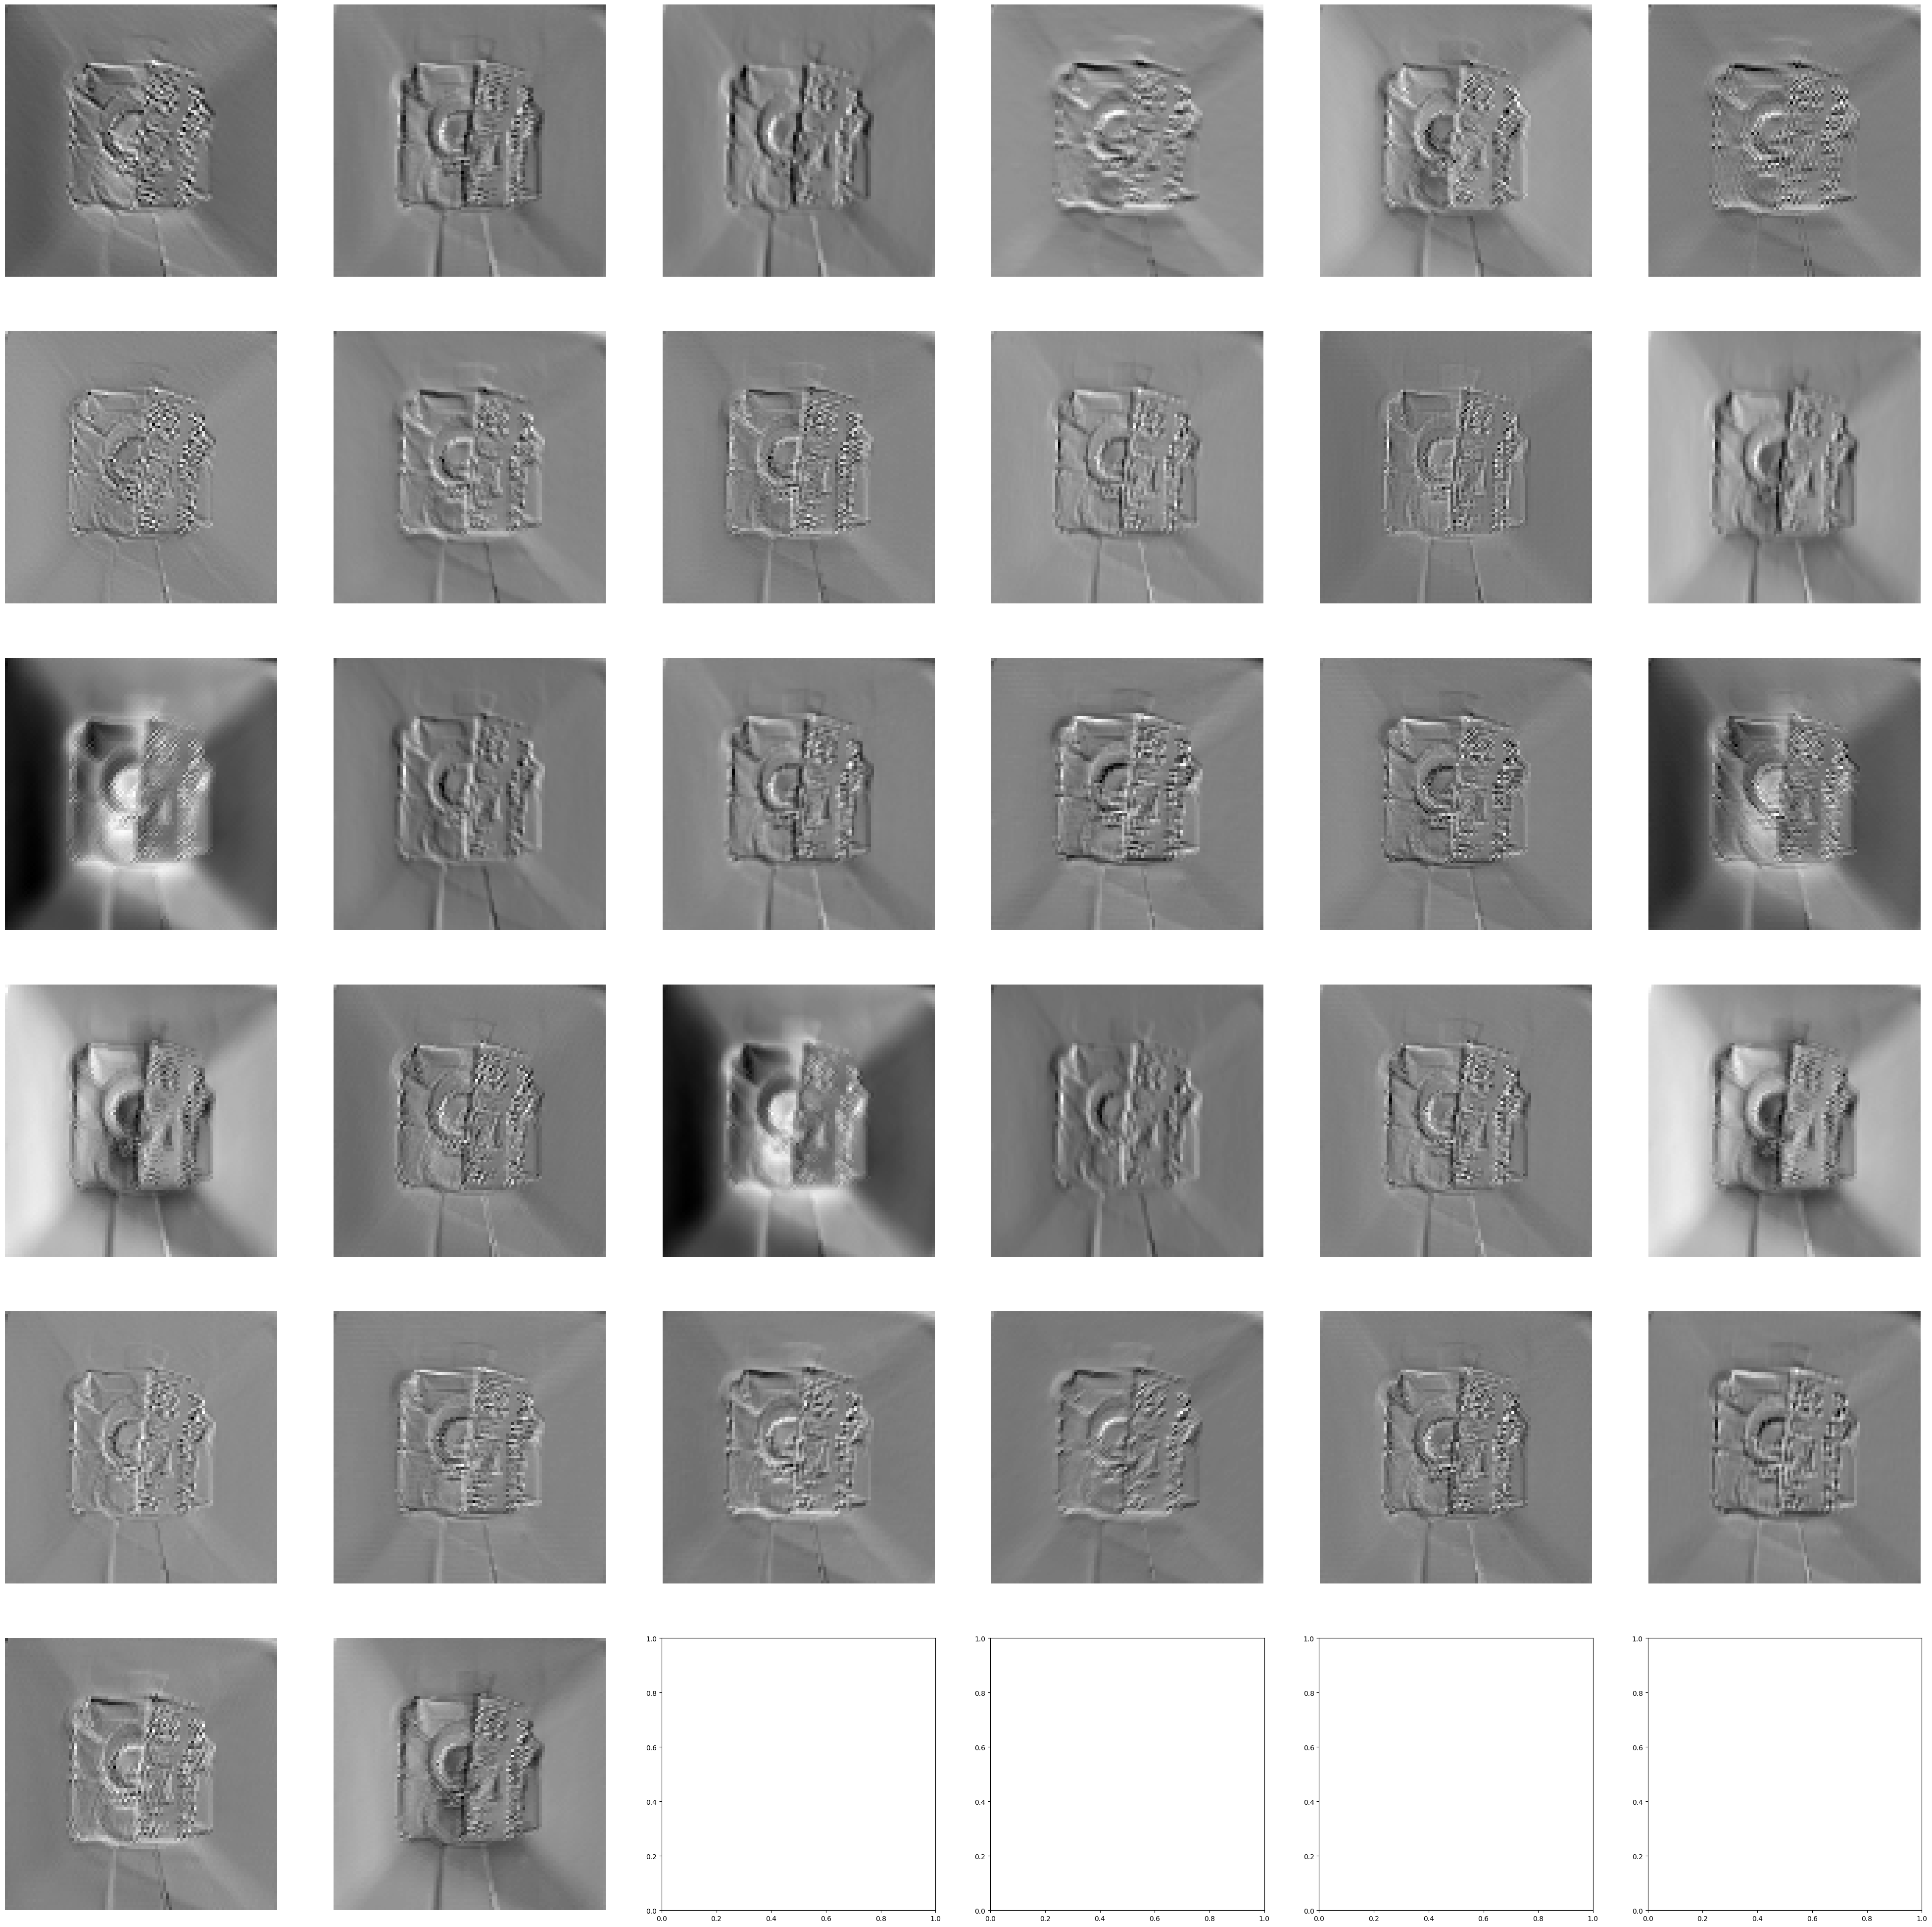

In [26]:
plotFeatureMaps(input_image, loaded_model, 0)

Also, setting the index to 2, we can visualize the feature maps from the max pooling layer

1/1 [==============================] - 0s 130ms/step
(49, 49)


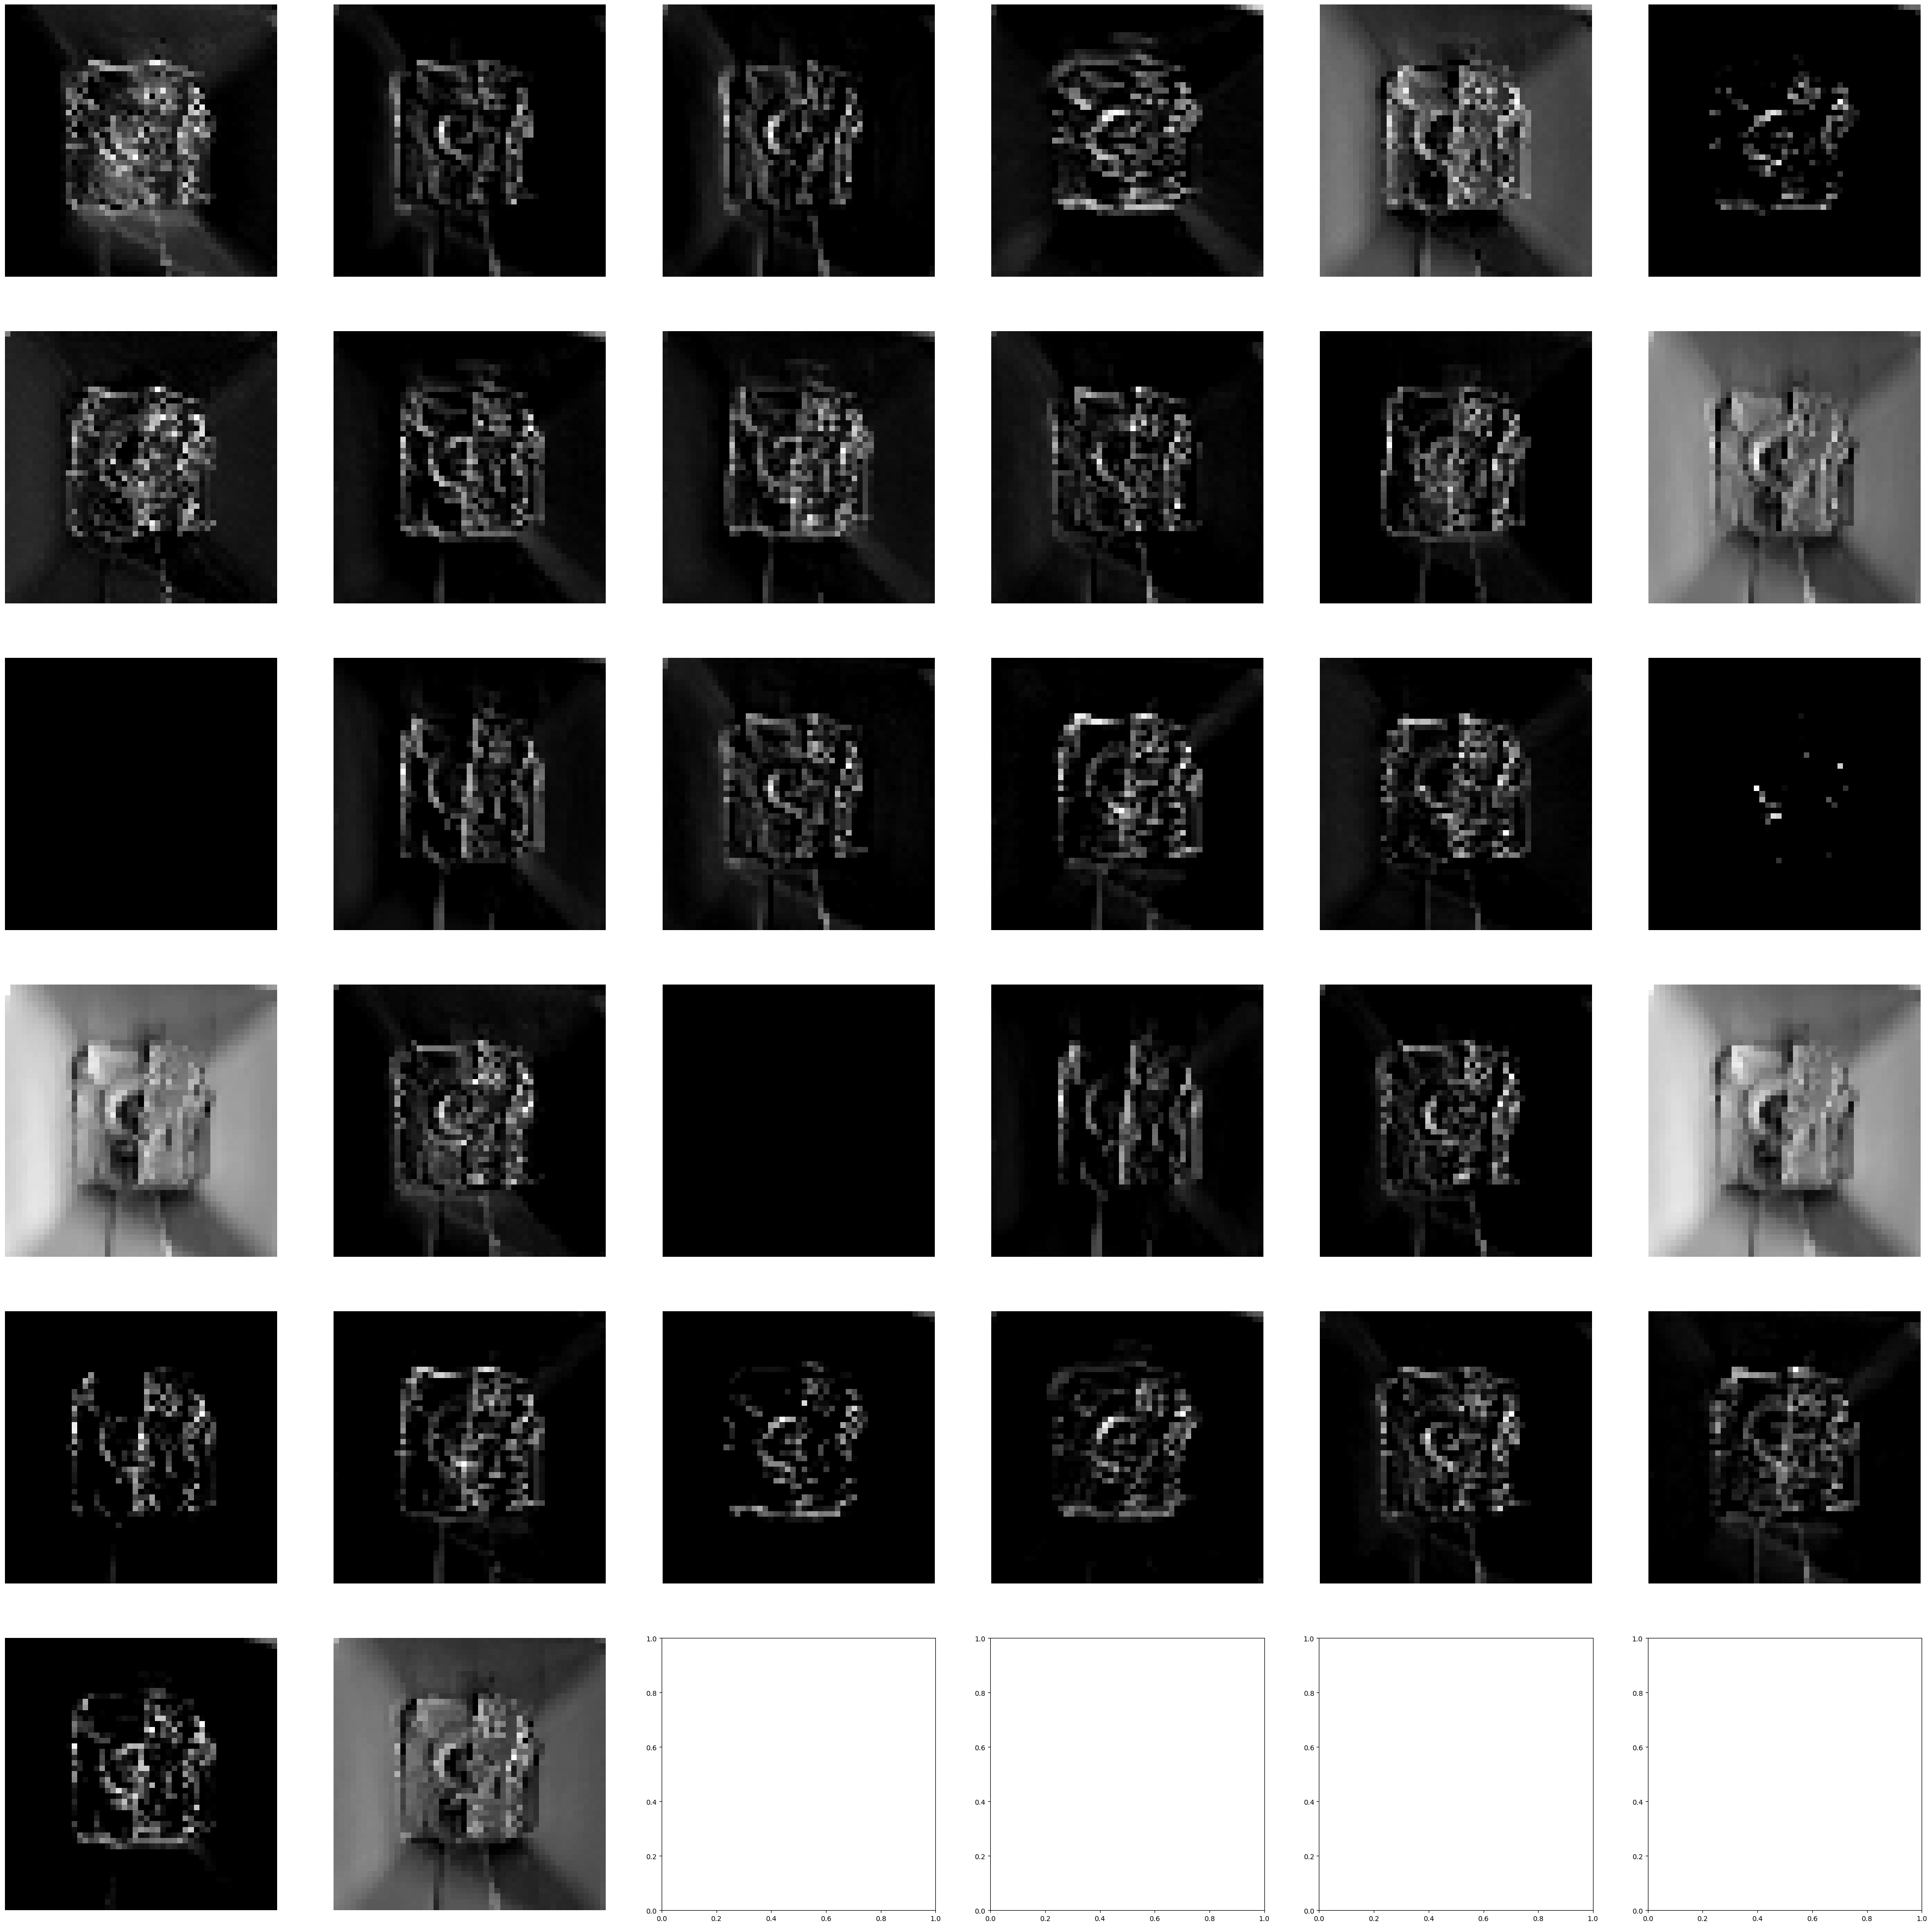

In [27]:
plotFeatureMaps(input_image, loaded_model, 2)

## Class Activation Mapping

Using the Grad-CAM algorithm, heatmaps of activations are plotted

In [101]:
def load_image(path):
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    plt.figure(figsize=(3, 3))
    plt.imshow(image, cmap='gray')
    plt.show()
    img = cv2.resize(image, (100, 100))
    img = img.reshape(-1, 100, 100, 1)
    img = img / 255
    return (image, img)
    

In [125]:
last_conv_layer = loaded_model.get_layer('activation')
grad_model = tf.keras.models.Model([loaded_model.inputs], [last_conv_layer.output, loaded_model.output])

In [113]:
def plot_cam(org_img, img):
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img)
        loss = predictions[:, np.argmax(predictions[0])]
    grads = tape.gradient(loss, conv_outputs)[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = np.sum(weights * conv_outputs[0], axis=-1)
    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)
    cam = cv2.resize(cam, (org_img.shape[1], org_img.shape[0]))
    plt.imshow(org_img)
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.colorbar(label='Intensity')
    plt.show()


### True postive cases:

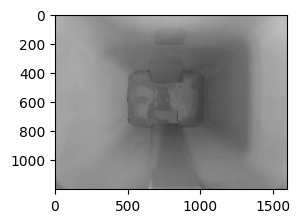

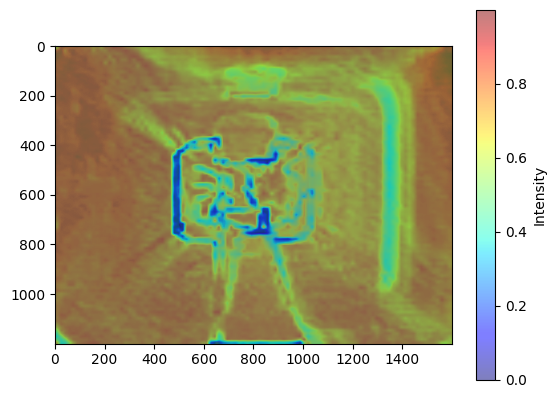

In [118]:
image1, img1 = load_image('Dataset/Train/empty/image102 (3).jpg')
plot_cam(image1, img1)

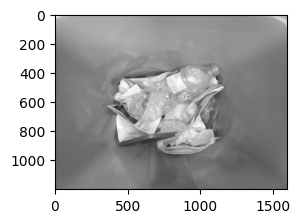

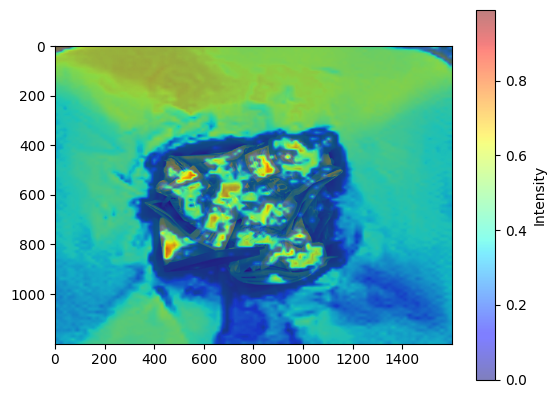

In [128]:
image2, img2 = load_image('Dataset/Train/half-full/image89.jpg')
plot_cam(image2, img2)

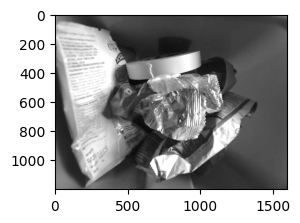

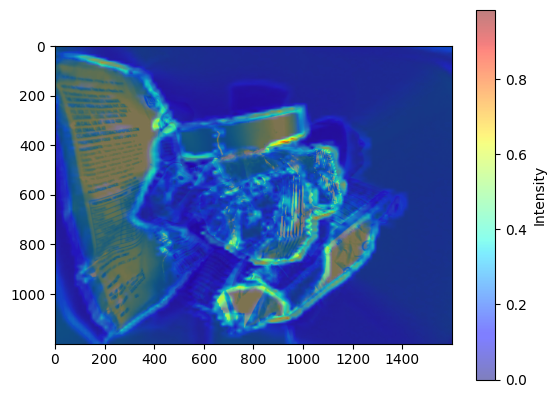

In [116]:
image3, img3 = load_image('Dataset/Test/full/image211.jpg')
plot_cam(image3, img3)

### Some false positive cases

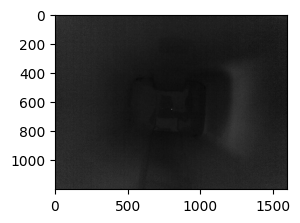

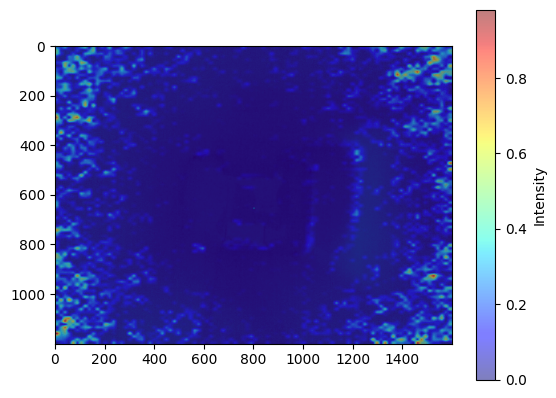

In [126]:
image4, img4 = load_image('Dataset/Test/empty/image150.jpg')
plot_cam(image4, img4)

1/1 [==============================] - 0s 187ms/step
(98, 98)


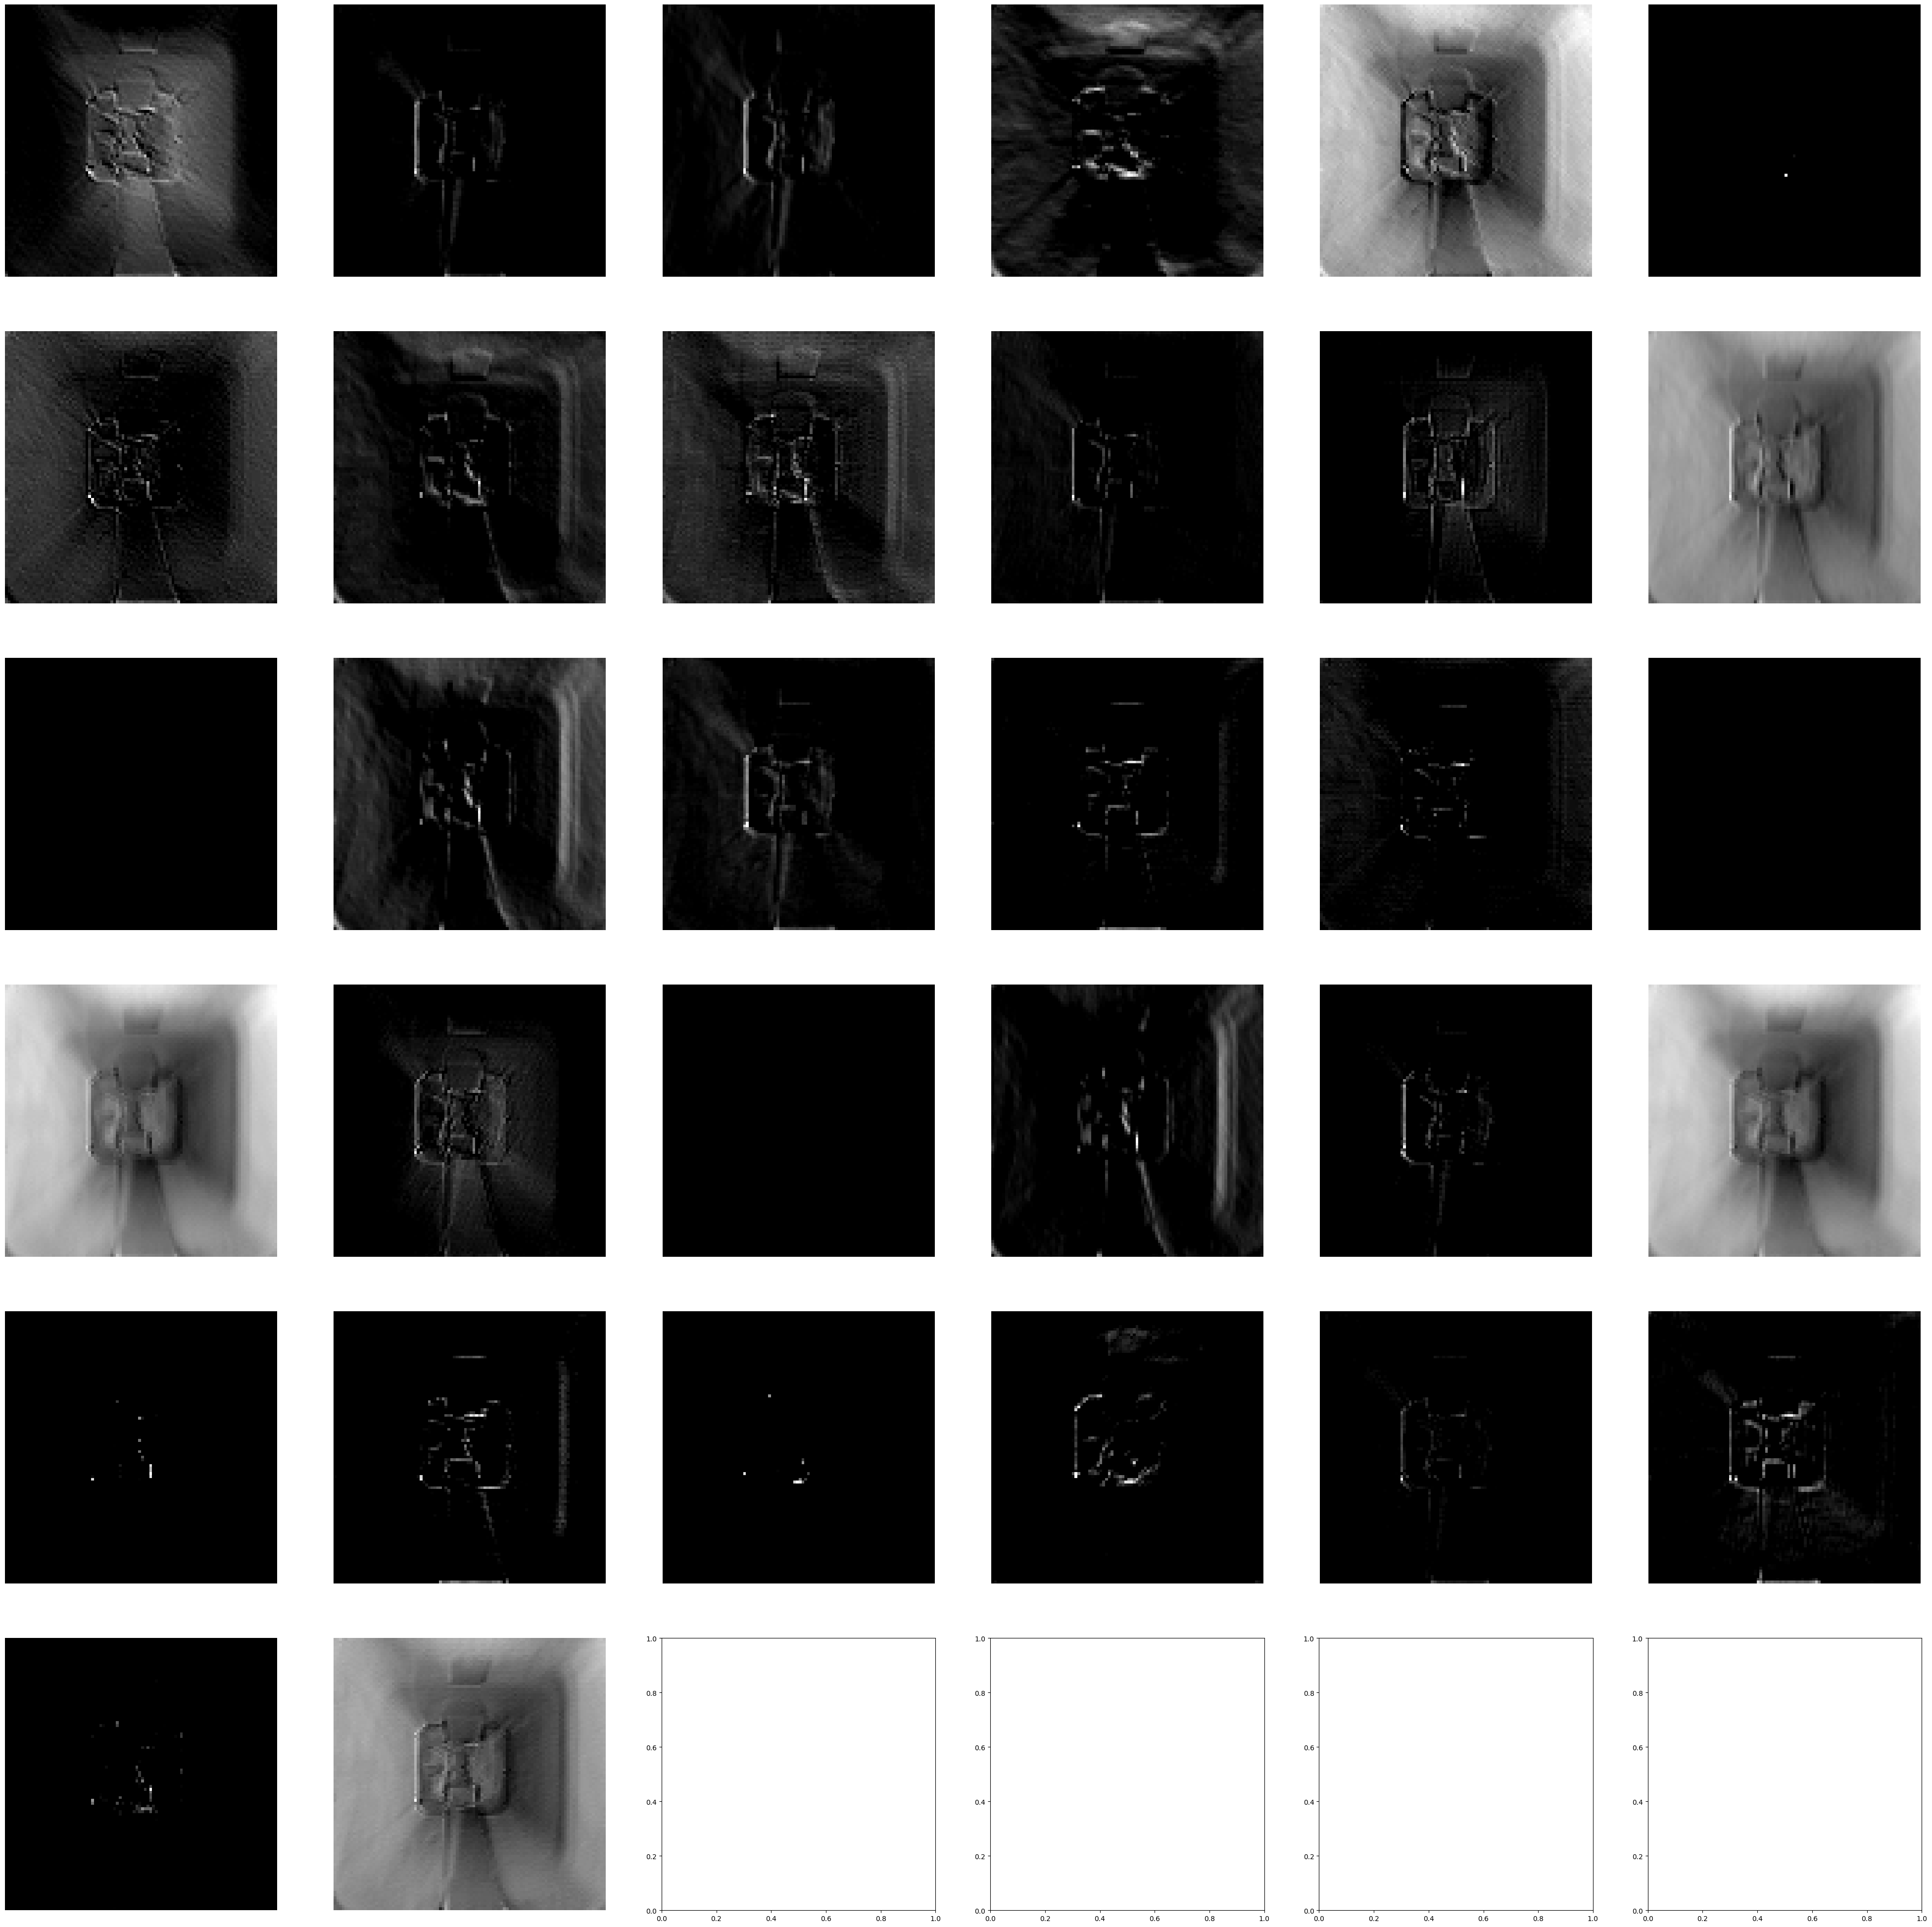

In [133]:
plotFeatureMaps(img1, loaded_model, 1)

1/1 [==============================] - 0s 203ms/step
(98, 98)


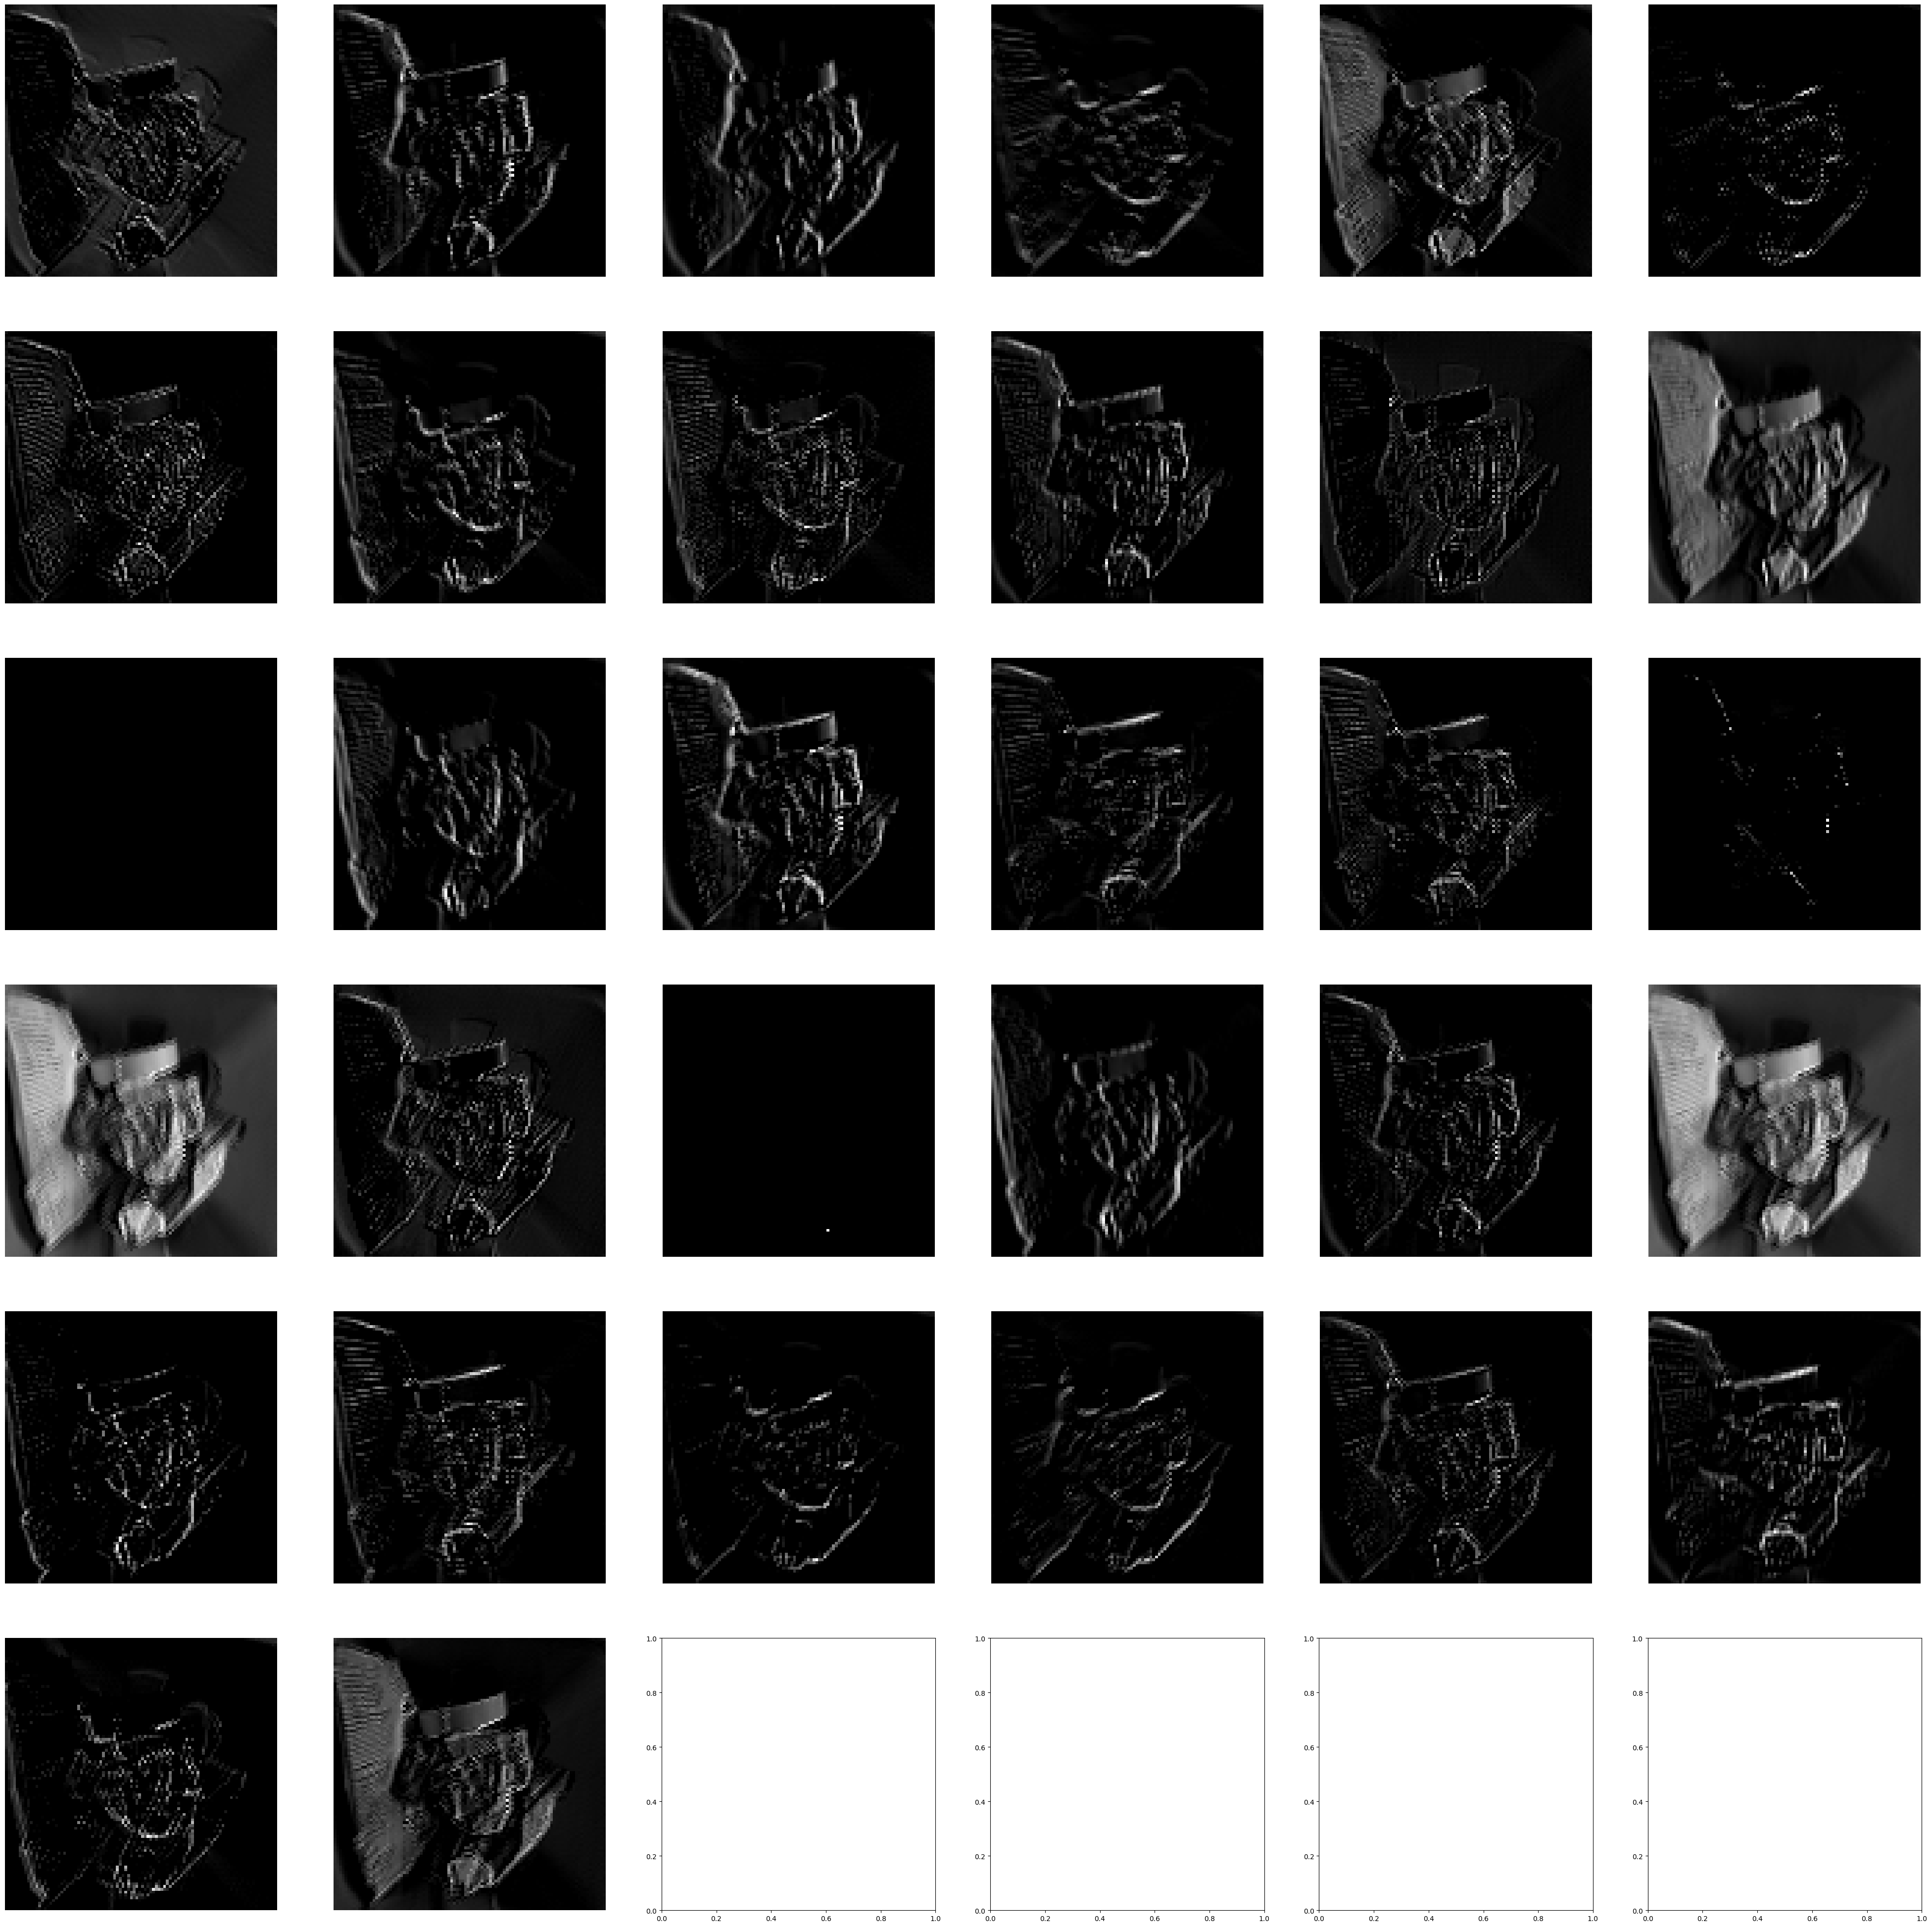

In [139]:
plotFeatureMaps(img3, loaded_model, 1)

1/1 [==============================] - 0s 172ms/step
(98, 98)


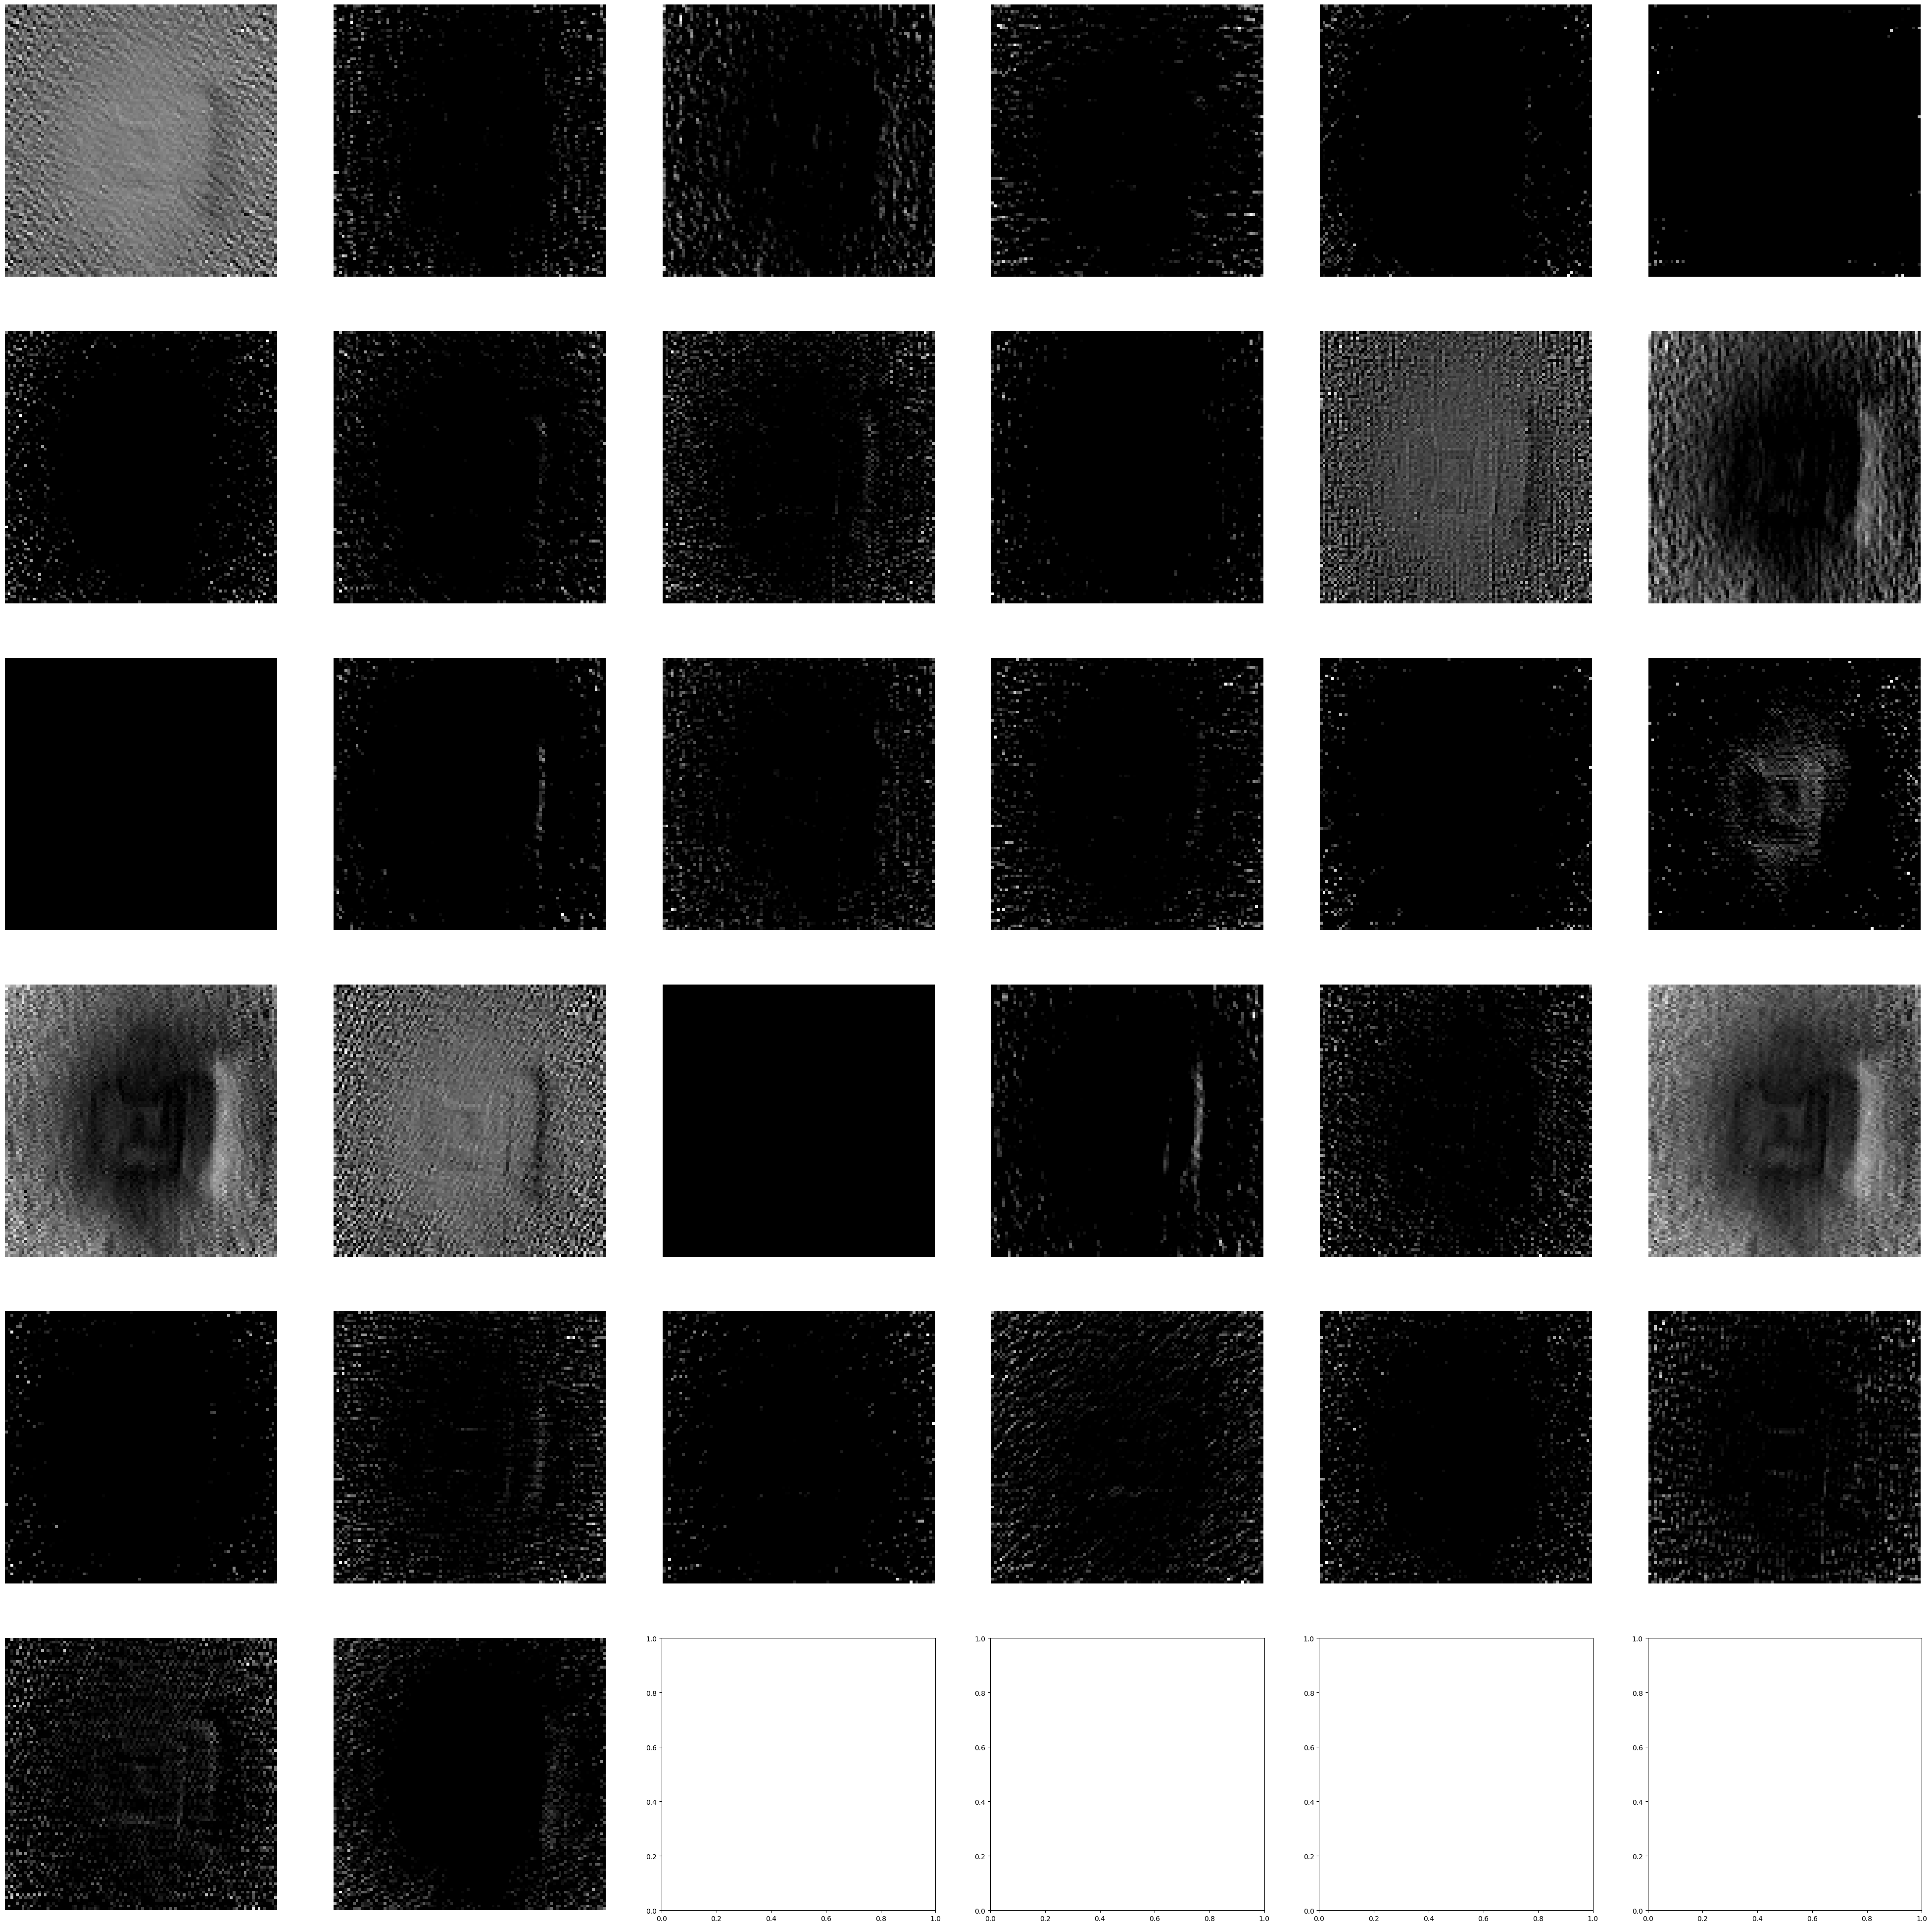

In [135]:
plotFeatureMaps(img4, loaded_model, 1)